import packages for QRS detection

In [8]:
import datetime  # for runtime assessment
import numpy as np
from scipy.signal import detrend, butter, filtfilt, lfilter
from scipy.signal.windows import hamming
from scipy.ndimage import rank_filter
import matplotlib.pyplot as plt

import packages for example

In [9]:
import scipy.io

# QRS detection example

## Load ECG data from Matlab file

Download data in Matlab format from: https://zenodo.org/record/6967256/files/MIMIC_PERform_1_min_normal.mat?download=1
Then specify the path to this file here:

In [10]:
matlab_file_path = '/Users/petercharlton/Downloads/new_downloads/MIMIC_PERform_1_min_normal.mat'

Load ECG data from a .mat file

In [52]:
mat_data = scipy.io.loadmat(matlab_file_path)  # Replace with your file path

# Access the ECG signal and sampling frequency from the 'data' structure
ecg_signal = mat_data['data']['ekg'][0,0]['v'][0][0]  # 'v' contains the ECG signal
fs = mat_data['data']['ekg'][0,0]['fs'][0][0][0][0]  # 'fs' contains the sampling frequency

## Plot the ECG data

In [53]:
# Create a time vector for plotting
time = np.arange(len(ecg_signal)) / fs

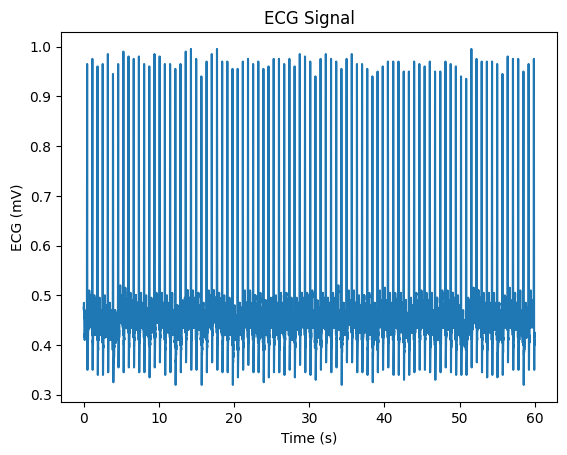

In [54]:
# Plot the ECG signal
plt.plot(time, ecg_signal)
plt.xlabel('Time (s)')
plt.ylabel('ECG (mV)')
plt.title('ECG Signal')
plt.show()

## Run 'UNSW' QRS detector algorithm

In [56]:
unswdata = UNSW_QRSDetector(ecg_signal,fs,mask=None,isplot=False)

You have not entered a mask. Continuing without.
125


TypeError: slice indices must be integers or None or have an __index__ method

# 'UNSW' QRS detector algorithm

In [28]:
def UNSW_QRSDetector(rawecg,fs,mask=None,isplot=False):
    
    starttime = datetime.datetime.now()
    
    if fs<50:
        raise Exception('This function requires a sampling rate of at least 50 Hz')
        
    if mask is None:
        finalmask = []
        print('You have not entered a mask. Continuing without.')
    else:
        finalmask = mask
    
    # Clean up Signal - hi pass, then low pass filter
    lphpdata = cleansignal(rawecg,fs)
    
    # Differentiator (to emphasise QRS)
    NumDiff = np.array([1, 0, -1]) / (2 * (1 / fs))
    diffdata = lfilter(NumDiff, [1], lphpdata)
    
    # Sort filter
    top = sortfilt1(lphpdata,round(fs*0.1),100)
    bot = sortfilt1(lphpdata,round(fs*0.1),0)
    envelope = (top-bot)
    envelope[envelope < 0] = 0
    feature = np.abs(diffdata * envelope)
    
    if isplot==1:
        raise Exception('Haven''t coded up this functionality from matlab')
    
    fc=6
    k=((fs/2)*0.0037)/fc
    Nh = round(k*fs)  # Heuristic for Hamming window 3dB point
    b = hamming(Nh, sym=True)
    # Approx fc Hz low pass
    b=b/np.sum(np.abs(b))
    a=[1]
    diffpower1 = np.abs(filtfilt(b, a, feature)) ** 0.5
    
    if isplot==1:
        raise Exception('Haven''t coded up this functionality from matlab')
    
    smashedSig = smashECG(diffpower1, finalmask)
    F = smashedFFT(smashedSig, fs, 2**14, isplot)
    f = np.arange(0, 2**13) * fs / 2**14
    range_indices = np.where((f >= 0.1) & (f < 4))[0]
    max_idx = np.argmax(F[range_indices])
    fftHRfreq = f[range_indices[max_idx]]
    
    # Update smoother feature signal
    HRmin = 1.5  # Hz: 90 BPM  (don't want to go much below this, will miss ectopics otherwise!)
    HRmax = 4.0  # Hz: 240 BPM  (Shouldn't see much above this)
    fc = np.median(2 * np.array([HRmin, fftHRfreq, HRmax]))  # Kills half of second harmonic and all of the rest
    k = ((fs / 2) * 0.0037) / fc
    Nh = round(k * fs)  # Heuristic for Hamming window 3dB point
    b = hamming(Nh, sym=True)
    b = b / np.sum(np.abs(b))
    a = [1]  # Approx fc Hz low pass 
    diffpower2 = np.abs(filtfilt(b, a, feature)) ** 0.5
    
    # Detect QRS points

    # Where isn't masked
    # Find valid indices
    valididx = np.setdiff1d(np.arange(len(diffpower2)), finalmask)
    # Maximum filter to get upper envelope
    Wsort = round(np.median(2 * np.array([fs, fs / fftHRfreq, fs / HRmax])))
    upperenv = sortfilt1(diffpower2, Wsort, 100)  # Morph Open
    upperenv = sortfilt1(upperenv, Wsort, 0)     # Morph Close
    lowerenv = sortfilt1(diffpower2, Wsort, 0)   # Morph Open
    lowerenv = sortfilt1(lowerenv, Wsort, 100)  # Morph Close
    QRSenv = upperenv - lowerenv

    # First pass: high threshold
    sensitivity = 1
    featureHeight = np.median(QRSenv[valididx])
    mainThreshold = 0.2 * featureHeight
    threshold = mainThreshold / sensitivity
    
    if isplot==1:
        raise Exception('Haven''t coded up this functionality from matlab')
    
    tpsidx = turning_points(diffpower2, threshold)
    qrs = tpsidx[tpsidx > 0]
    qrs = np.setdiff1d(qrs, finalmask)
    m_rr, rr_list, n_rr, n_sections = calculate_rr_interval(qrs, finalmask, fs)
    
    # Back-track to find possible missed beats
    # Lower threshold
    sensitivity = 2
    threshold = main_threshold / sensitivity
    tpsidx = turning_points(diffpower2, threshold)
    qrs2 = tpsidx[tpsidx > 0]

    # Fill in gaps
    newmask = np.union1d(finalmask, qrs)
    temp = np.zeros(len(diffpower2) + 2)
    temp[newmask + 1] = 1
    
    # Fill in sections less than 1.5*mRR seconds;

    for i in range(1, len(temp)):
        if temp[i] - temp[i - 1] == -1:
            start = i
        if temp[i] - temp[i - 1] == 1 and (i - 1) - start < 1.5 * m_rr:
            temp[start:(i - 1)] = 1
    newmask = np.where(temp[1:-1] == 1)[0]

    # Only keep newly found QRS between long beats
    qrs2 = np.setdiff1d(qrs2, newmask)
    # Add them to the old QRS (found using low sensitivity)
    qrs = np.union1d(qrs, qrs2)
    m_rr, rr_list, n_rr, n_sections = calculate_rr_interval(qrs, finalmask, fs)

    # 3rd pass: Highest threshold
    # Back-track to remove possible wrong beats
    sensitivity = 0.5
    threshold = main_threshold / sensitivity
    tpsidx = turning_points(diffpower2, threshold)
    qrs3 = tpsidx[tpsidx > 0]
    qrs3 = np.setdiff1d(qrs3, finalmask)

    # find indices of RR intervals that are too short
    short_rr_idx = []
    for i in range(1, len(qrs)):
        if qrs[i] - qrs[i - 1] < 0.5 * m_rr:
            short_rr_idx.extend(range(qrs[i - 1], qrs[i]))

    qrs3 = np.intersect1d(qrs3, short_rr_idx)
    qrs = np.setdiff1d(qrs, short_rr_idx)
    qrs = np.union1d(qrs, qrs3)
    m_rr, rr_list, n_rr, n_sections = calculate_rr_interval(qrs, finalmask, fs)

    if isplot == 1:
        raise Exception('Haven''t coded up this functionality from matlab')

    unswdata = {
        'qrs': qrs,
        'RRlist': rr_list,
        'nRR': n_rr,
        'mRR': m_rr,
        'nSections': n_sections,
        'runtime': datetime.now() - starttime
    }
    
    return unswdata

In [29]:
def turning_points(x, threshold):
    ##
    # turning_points
    # Helper function - finds the locations of peaks and troughs of x 
    # according to the threshold
    #
    # Original version Stephen Redmond
    # Modified by Philip de Chazal 30/5/07
    #

    x = np.append(x, [x[-1] + np.finfo(float).eps, x[-1]])
    
    #tps=1 when at a peak and tps=-1 when at a through, tps=0 elsewhere
    tps = np.concatenate(([0], -np.sign(np.diff(np.sign(np.diff(x)))), [0]))
    tpidx = np.where(tps != 0)[0]
    
    # index of all turning points
    pkth = tps[tpidx]
    
    # start searching for turning point using threshold
    i = 0
    inpeak = 0
    possibleidx = None
    ref = x[0]
    confirmed = np.full(len(pkth), np.nan)
    k = 0
    
    while i < len(tpidx):
        
        # The aim of the following code is to eliminate all the local peaks and
        # troughs. A local peak or trough occurs when the height difference
        # between a peak and trough is less than 'threshold's
        
        # find first pk/tr
        if inpeak == 0 and abs(x[tpidx[i]] - ref) > threshold:
            inpeak = pkth[i]
            possibleidx = tpidx[i]
            ref = x[tpidx[i]]

        # if looking for peak
        if inpeak == 1 and (ref - x[tpidx[i]]) > threshold:
            # peak found when next trough is more then threshold away from
            # current peak
            confirmed[k] = possibleidx * tps[possibleidx]
            k += 1
            # this lower point could be next trough
            possibleidx = tpidx[i]
            ref = x[tpidx[i]]
            inpeak = -1
        elif inpeak == 1 and x[tpidx[i]] > ref:
            possibleidx = tpidx[i]
            ref = x[tpidx[i]]

        # if looking for trough
        if inpeak == -1 and (x[tpidx[i]] - ref) > threshold:
            # trough found when next peak is more then threshold away from
            # current trough
            confirmed[k] = possibleidx * tps[possibleidx]
            k += 1
            # this higher point could be next peak
            possibleidx = tpidx[i]
            ref = x[tpidx[i]]
            inpeak = 1
        elif inpeak == -1 and x[tpidx[i]] < x[possibleidx]:
            possibleidx = tpidx[i]
            ref = x[tpidx[i]]

        i += 1
    
    confirmed = confirmed[~np.isnan(confirmed)].astype(int)
    
    return confirmed

In [30]:
def calculate_rr_interval(qrs, mask, fs):
    rr_list = []
    n_sections = 1

    for k in range(len(qrs) - 1):
        range_vals = np.arange(qrs[k], qrs[k + 1])
        if not np.intersect1d(range_vals, mask).size:
            rr_list.append(qrs[k + 1] - qrs[k])
        else:
            n_sections += 1

    rr_list = np.array(rr_list)
    rr_list = rr_list[rr_list < 5 * fs]
    
    if len(rr_list) > 0:
        m_rr = np.mean(rr_list)
        n_rr = len(rr_list)
    else:
        m_rr = np.nan
        n_rr = 0

    return m_rr, rr_list, n_rr, n_sections

In [31]:
def smashECG(ECG,mask):
    # smashECG
    # Helper function - splits ECG into clean sections according to the mask
    # mask is the sample locations of null signal
    
    expandedMask = np.zeros(len(ECG) + 2, dtype=int)  # Length of ECG + 2
    expandedMask[0] = 1
    expandedMask[-1] = 1
    expandedMask[mask] = 1
    
    startend = np.diff(expandedMask)
    starts = np.where(startend == -1)[0]
    ends = np.where(startend == 1)[0] - 1
    
    smashedECG = []
    for i in range(len(starts)):
        smashedECG.append(ECG[starts[i]:ends[i] + 1])    
    
    return smashedECG

In [32]:
def sortfilt1(x,n,p):
    
    N = len(x)
    
    if p>100:
        p=100
    elif p<0:
        p=0
    
    if n % 2 == 0:
        N1 = (n/2)-1
        N2 = (n/2)
    else:
        N1 = (n-1)/2
        N2 = (n-1)/2
    
    y = np.zeros_like(x)
    
    USE_MEX = 0
    if USE_MEX:
        raise Exception('Haven''t included the functionality from Matlab to use the c-code functions')
    else:
        y = np.zeros(N)
        for i in range(1,N+1):
            A = max(1, i-N1)
            B = min(N, i+N2)
            P = 1 + round((p/100)*(B-A))
            Z = np.sort(x[A-1:B])
            y[i-1] = Z[P-1]
	
    return y

In [33]:
def myfiltfilt(b,a,x):
    
    if len(x) <= 3*max([len(b)-1,len(a)-1]):
        y = np.zeros_like(x)
    else:
        y = filtfilt(b,a,x)
        
    return y

In [43]:
def cleansignal(x,fs):
    # cleansignal
    # Helper function - baseline removal then high pass (0.7 Hz) filtering followed by low pass (20 Hz) filtering
    
    x = detrend(x)
    
    # Remove baseline
    baseline = sortfilt1(x,round(0.5*fs),50)
    meddata = x - baseline
    
    if fs>600 or fs<400:
        
        # hpf - used to eliminate dc component or low frequency drift.
        b, a = butter(7, 0.7 / (fs / 2), btype='high')
        hpdata = myfiltfilt(b,a,meddata)

        # low pass linear phase filter
        b, a = butter(7, 20 / (fs / 2), btype='low')
        lphpdata = myfiltfilt(b,a,hpdata)
    
    else: # i.e fs<600 & fs>400
        # load filter coefficients, first FIR HI Pass
        numhpz = np.array([
            -3.9221262304045220e-004,
            -3.9248810588436559e-004,
            -3.9278557879888544e-004,
            -3.9310503058520639e-004,
            -3.9344644921534048e-004,
            -3.9380982183519360e-004,
            -3.9419513476445281e-004,
            -3.9460237349535755e-004,
            -3.9503152269589547e-004,
            -3.9548256620951260e-004,
            -3.9595548705403428e-004,
            -3.9645026742427284e-004,
            -3.9696688869288481e-004,
            -3.9750533140803603e-004,
             -3.9806557529708554e-004,
             -3.9864759927138948e-004,
             -3.9925138141260049e-004,
             -3.9987689899230482e-004,
             -4.0052412845809971e-004,
             -4.0119304544340392e-004,
             -4.0188362476384267e-004,
             -4.0259584041861963e-004,
             -4.0332966559388861e-004,
             -4.0408507266161576e-004,
             -4.0486203318067509e-004,
             -4.0566051789899297e-004,
             -4.0648049675459143e-004,
             -4.0732193887510872e-004,
             -4.0818481258101248e-004,
             -4.0906908538611221e-004,
             -4.0997472399742052e-004,
             -4.1090169431744780e-004,
             -4.1184996144816321e-004,
             -4.1281948968544544e-004,
             -4.1381024253105267e-004,
             -4.1482218267794918e-004,
             -4.1585527203154391e-004,
             -4.1690947169599328e-004,
             -4.1798474198001978e-004,
             -4.1908104240096660e-004,
             -4.2019833168408839e-004,
             -4.2133656776299853e-004,
             -4.2249570778469885e-004,
             -4.2367570810830960e-004,
             -4.2487652430682477e-004,
             -4.2609811117052588e-004,
             -4.2734042270785072e-004,
             -4.2860341214514641e-004,
             -4.2988703193259199e-004,
             -4.3119123374318305e-004,
             -4.3251596847251775e-004,
             -4.3386118624743134e-004,
             -4.3522683641794362e-004,
             -4.3661286757293587e-004,
             -4.3801922752547393e-004,
             -4.3944586332736934e-004,
             -4.4089272126770964e-004,
             -4.4235974687193173e-004,
             -4.4384688490793135e-004,
             -4.4535407938599834e-004,
             -4.4688127356072138e-004,
             -4.4842840993406050e-004,
             -4.4999543025777105e-004,
             -4.5158227553346796e-004,
             -4.5318888601808148e-004,
             -4.5481520122371251e-004,
             -4.5646115991992769e-004,
             -4.5812670013784516e-004,
             -4.5981175917219740e-004,
             -4.6151627357636396e-004,
             -4.6324017918234861e-004,
             -4.6498341108255393e-004,
             -4.6674590364742866e-004,
             -4.6852759051817098e-004,
             -4.7032840461614517e-004,
             -4.7214827814207375e-004,
             -4.7398714257819528e-004,
             -4.7584492869213947e-004,
             -4.7772156654013855e-004,
             -4.7961698546680862e-004,
             -4.8153111411124833e-004,
             -4.8346388040789562e-004,
             -4.8541521158890807e-004,
             -4.8738503418738839e-004,
             -4.8937327404175953e-004,
             -4.9137985629451328e-004,
             -4.9340470539832549e-004,
             -4.9544774512297915e-004,
             -4.9750889854377218e-004,
             -4.9958808806302608e-004,
             -5.0168523539876708e-004,
             -5.0380026159520795e-004,
             -5.0593308702328395e-004,
             -5.0808363138209005e-004,
             -5.1025181370564180e-004,
             -5.1243755236310385e-004,
             -5.1464076506255879e-004,
             -5.1686136885394107e-004,
             -5.1909928013370125e-004,
             -5.2135441464469783e-004,
             -5.2362668748273417e-004,
             -5.2591601309848939e-004,
             -5.2822230529983583e-004,
             -5.3054547725488253e-004,
             -5.3288544150024650e-004,
             -5.3524210993461600e-004,
             -5.3761539383509666e-004,
             -5.4000520384260965e-004,
             -5.4241144998692860e-004,
             -5.4483404167353410e-004,
             -5.4727288769203014e-004,
             -5.4972789622166173e-004,
             -5.5219897483346010e-004,
             -5.5468603049121760e-004,
             -5.5718896956008079e-004,
             -5.5970769780566069e-004,
             -5.6224212039870751e-004,
             -5.6479214191959494e-004,
             -5.6735766636233412e-004,
             -5.6993859713464975e-004,
             -5.7253483706756303e-004,
             -5.7514628841464233e-004,
             -5.7777285285410705e-004,
             -5.8041443149969190e-004,
             -5.8307092489380606e-004,
             -5.8574223302553766e-004,
             -5.8842825531853454e-004,
             -5.9112889064588756e-004,
             -5.9384403733179895e-004,
             -5.9657359315098512e-004,
             -5.9931745533793601e-004,
             -6.0207552058760111e-004,
             -6.0484768506032589e-004,
             -6.0763384438548298e-004,
             -6.1043389366675189e-004,
             -6.1324772748252705e-004,
             -6.1607523989440230e-004,
             -6.1891632444770021e-004,
             -6.2177087417691402e-004,
             -6.2463878161027884e-004,
             -6.2751993877498320e-004,
             -6.3041423719100310e-004,
             -6.3332156789659526e-004,
             -6.3624182142818747e-004,
             -6.3917488784185901e-004,
             -6.4212065670716915e-004,
             -6.4507901711889008e-004,
             -6.4804985769664845e-004,
             -6.5103306658998599e-004,
             -6.5402853148223731e-004,
             -6.5703613959677658e-004,
             -6.6005577769744604e-004,
             -6.6308733209736776e-004,
             -6.6613068866025276e-004,
             -6.6918573280565197e-004,
             -6.7225234951211036e-004,
             -6.7533042332464576e-004,
             -6.7841983835399385e-004,
             -6.8152047828467740e-004,
             -6.8463222638380050e-004,
             -6.8775496549020585e-004,
             -6.9088857803816222e-004,
             -6.9403294604745806e-004,
             -6.9718795113443677e-004,
             -7.0035347451613788e-004,
             -7.0352939701083387e-004,
             -7.0671559904783956e-004,
             -7.0991196066823065e-004,
             -7.1311836153086698e-004,
             -7.1633468091565188e-004,
             -7.1956079773151924e-004,
             -7.2279659051566138e-004,
             -7.2604193744291667e-004,
             -7.2929671632825652e-004,
             -7.3256080463095382e-004,
             -7.3583407945772056e-004,
             -7.3911641757537538e-004,
             -7.4240769540201770e-004,
             -7.4570778902800533e-004,
             -7.4901657419952075e-004,
             -7.5233392634805663e-004,
             -7.5565972057633720e-004,
             -7.5899383166889252e-004,
             -7.6233613409854386e-004,
             -7.6568650203067789e-004,
             -7.6904480932371815e-004,
             -7.7241092954110756e-004,
             -7.7578473594992910e-004,
             -7.7916610152794813e-004,
             -7.8255489896851234e-004,
             -7.8595100068665279e-004,
             -7.8935427881863293e-004,
             -7.9276460523487768e-004,
             -7.9618185153881036e-004,
             -7.9960588907068068e-004,
             -8.0303658892049139e-004,
             -8.0647382192052300e-004,
             -8.0991745866543837e-004,
             -8.1336736950144740e-004,
             -8.1682342454097491e-004,
             -8.2028549366745004e-004,
             -8.2375344653398859e-004,
             -8.2722715257538932e-004,
             -8.3070648100818441e-004,
             -8.3419130083789493e-004,
             -8.3768148086229535e-004,
             -8.4117688967936686e-004,
             -8.4467739568725862e-004,
             -8.4818286709532138e-004,
             -8.5169317192394193e-004,
             -8.5520817801219623e-004,
             -8.5872775302191673e-004,
             -8.6225176444585695e-004,
             -8.6578007959912582e-004,
             -8.6931256565128147e-004,
             -8.7284908960165821e-004,
             -8.7638951830460094e-004,
             -8.7993371846263363e-004,
             -8.8348155664009706e-004,
             -8.8703289926243508e-004,
             -8.9058761262395111e-004,
             -8.9414556289069982e-004,
             -8.9770661610938363e-004,
             -9.0127063820671081e-004,
             -9.0483749500043487e-004,
             -9.0840705219989834e-004,
             -9.1197917541398536e-004,
             -9.1555373015291973e-004,
             -9.1913058183862675e-004,
             -9.2270959580295923e-004,
             -9.2629063729713365e-004,
             -9.2987357150189996e-004,
             -9.3345826351563647e-004,
             -9.3704457838072802e-004,
             -9.4063238107318381e-004,
             -9.4422153651356922e-004,
             -9.4781190957412957e-004,
             -9.5140336507721778e-004,
             -9.5499576780775253e-004,
             -9.5858898251352845e-004,
             -9.6218287391255561e-004,
             -9.6577730669536390e-004,
             -9.6937214553583656e-004,
             -9.7296725508833905e-004,
             -9.7656249999973632e-004,
             -9.8015774491159524e-004,
             -9.8375285446517836e-004,
             -9.8734769330334243e-004,
             -9.9094212608782429e-004,
             -9.9453601748523903e-004,
             -9.9812923219385415e-004,
             -1.0017216349224919e-003,
             -1.0053130904257195e-003,
             -1.0089034634862156e-003,
             -1.0124926189272569e-003,
             -1.0160804216190922e-003,
             -1.0196667364847556e-003,
             -1.0232514284986278e-003,
             -1.0268343627016230e-003,
             -1.0304154041975936e-003,
             -1.0339944181621320e-003,
             -1.0375712698467256e-003,
             -1.0411458245869116e-003,
             -1.0447179477994966e-003,
             -1.0482875049988524e-003,
             -1.0518543617935349e-003,
             -1.0554183838904399e-003,
             -1.0589794371099869e-003,
             -1.0625373873757048e-003,
             -1.0660921007374655e-003,
             -1.0696434433600161e-003,
             -1.0731912815365435e-003,
             -1.0767354816956800e-003,
             -1.0802759103976426e-003,
             -1.0838124343488292e-003,
             -1.0873449204001388e-003,
             -1.0908732355563375e-003,
             -1.0943972469772858e-003,
             -1.0979168219879746e-003,
             -1.1014318280760081e-003,
             -1.1049421329050329e-003,
             -1.1084476043126288e-003,
             -1.1119481103204422e-003,
             -1.1154435191360510e-003,
             -1.1189336991638207e-003,
             -1.1224185189900567e-003,
             -1.1258978474244317e-003,
             -1.1293715534659461e-003,
             -1.1328395063340180e-003,
             -1.1363015754592711e-003,
             -1.1397576304990355e-003,
             -1.1432075413341247e-003,
             -1.1466511780786042e-003,
             -1.1500884110797621e-003,
             -1.1535191109296183e-003,
             -1.1569431484618753e-003,
             -1.1603603947651097e-003,
             -1.1637707211809407e-003,
             -1.1671739993140997e-003,
             -1.1705701010308906e-003,
             -1.1739588984724871e-003,
             -1.1773402640506522e-003,
             -1.1807140704573960e-003,
             -1.1840801906769292e-003,
             -1.1874384979694140e-003,
             -1.1907888659011961e-003,
             -1.1941311683316233e-003,
             -1.1974652794231658e-003,
             -1.2007910736516827e-003,
             -1.2041084257999564e-003,
             -1.2074172109732253e-003,
             -1.2107173045970243e-003,
             -1.2140085824255307e-003,
             -1.2172909205413818e-003,
             -1.2205641953699415e-003,
             -1.2238282836715085e-003,
             -1.2270830625561984e-003,
             -1.2303284094840141e-003,
             -1.2335642022700769e-003,
             -1.2367903190831141e-003,
             -1.2400066384698333e-003,
             -1.2432130393304434e-003,
             -1.2464094009542839e-003,
             -1.2495956029886976e-003,
             -1.2527715254834480e-003,
             -1.2559370488653449e-003,
             -1.2590920539529049e-003,
             -1.2622364219615281e-003,
             -1.2653700345104121e-003,
             -1.2684927736165063e-003,
             -1.2716045217140651e-003,
             -1.2747051616462880e-003,
             -1.2777945766759185e-003,
             -1.2808726504871461e-003,
             -1.2839392671953808e-003,
             -1.2869943113393892e-003,
             -1.2900376679022599e-003,
             -1.2930692223035193e-003,
             -1.2960888604027364e-003,
             -1.2990964685181941e-003,
             -1.3020919334088329e-003,
             -1.3050751423026425e-003,
             -1.3080459828813712e-003,
             -1.3110043432925497e-003,
             -1.3139501121594164e-003,
             -1.3168831785717470e-003,
             -1.3198034321038369e-003,
             -1.3227107628081163e-003,
             -1.3256050612268254e-003,
             -1.3284862183889751e-003,
             -1.3313541258235550e-003,
             -1.3342086755521784e-003,
             -1.3370497601056619e-003,
             -1.3398772725167229e-003,
             -1.3426911063327707e-003,
             -1.3454911556128766e-003,
             -1.3482773149433404e-003,
             -1.3510494794107422e-003,
             -1.3538075446614803e-003,
             -1.3565514068476937e-003,
             -1.3592809626683643e-003,
             -1.3619961093534303e-003,
             -1.3646967446821229e-003,
             -1.3673827669748412e-003,
             -1.3700540751065695e-003,
             -1.3727105685012108e-003,
             -1.3753521471465584e-003,
             -1.3779787115855160e-003,
             -1.3805901629320725e-003,
             -1.3831864028643771e-003,
             -1.3857673336384166e-003,
             -1.3883328580797424e-003,
             -1.3908828796016820e-003,
             -1.3934173021952581e-003,
             -1.3959360304379980e-003,
             -1.3984389695099390e-003,
             -1.4009260251664952e-003,
             -1.4033971037781005e-003,
             -1.4058521123089618e-003,
             -1.4082909583258061e-003,
             -1.4107135500131848e-003,
             -1.4131197961569702e-003,
             -1.4155096061658861e-003,
             -1.4178828900640824e-003,
             -1.4202395585006765e-003,
             -1.4225795227437799e-003,
             -1.4249026947011452e-003,
             -1.4272089869017883e-003,
             -1.4294983125168104e-003,
             -1.4317705853552957e-003,
             -1.4340257198691398e-003,
             -1.4362636311438218e-003,
             -1.4384842349378915e-003,
             -1.4406874476344963e-003,
             -1.4428731862975550e-003,
             -1.4450413686171440e-003,
             -1.4471919129757605e-003,
             -1.4493247384044024e-003,
             -1.4514397646015829e-003,
             -1.4535369119363767e-003,
             -1.4556161014574929e-003,
             -1.4576772548770896e-003,
             -1.4597202946002980e-003,
             -1.4617451437055880e-003,
             -1.4637517259590640e-003,
             -1.4657399658114950e-003,
             -1.4677097884125247e-003,
             -1.4696611195910063e-003,
             -1.4715938858872323e-003,
             -1.4735080145342307e-003,
             -1.4754034334586432e-003,
             -1.4772800713098080e-003,
             -1.4791378574218648e-003,
             -1.4809767218579694e-003,
             -1.4827965953846645e-003,
             -1.4845974094806315e-003,
             -1.4863790963534065e-003,
             -1.4881415889167462e-003,
             -1.4898848208181634e-003,
             -1.4916087264221886e-003,
             -1.4933132408289761e-003,
             -1.4949982998602820e-003,
             -1.4966638400806013e-003,
             -1.4983097987768005e-003,
             -1.4999361139840155e-003,
             -1.5015427244669563e-003,
             -1.5031295697420038e-003,
             -1.5046965900619739e-003,
             -1.5062437264447403e-003,
             -1.5077709206096951e-003,
             -1.5092781150915857e-003,
             -1.5107652531282604e-003,
             -1.5122322787354085e-003,
             -1.5136791366732690e-003,
             -1.5151057724752683e-003,
             -1.5165121324251267e-003,
             -1.5178981635806494e-003,
             -1.5192638137517241e-003,
             -1.5206090315284637e-003,
             -1.5219337662571789e-003,
             -1.5232379680680040e-003,
             -1.5245215878532715e-003,
             -1.5257845772935100e-003,
             -1.5270268888284955e-003,
             -1.5282484756937668e-003,
             -1.5294492918942310e-003,
             -1.5306292922116836e-003,
             -1.5317884322393392e-003,
             -1.5329266683147052e-003,
             -1.5340439575981038e-003,
             -1.5351402580225835e-003,
             -1.5362155283022733e-003,
             -1.5372697279690765e-003,
             -1.5383028173211741e-003,
             -1.5393147574695250e-003,
             -1.5403055103129742e-003,
             -1.5412750385552525e-003,
             -1.5422233056805405e-003,
             -1.5431502760040860e-003,
             -1.5440559146133672e-003,
             -1.5449401874162664e-003,
             -1.5458030611235122e-003,
             -1.5466445032538019e-003,
             -1.5474644820950159e-003,
             -1.5482629668209223e-003,
             -1.5490399273316207e-003,
             -1.5497953344156923e-003,
             -1.5505291595796691e-003,
             -1.5512413752336504e-003,
             -1.5519319545563874e-003,
             -1.5526008715434358e-003,
             -1.5532481010048266e-003,
             -1.5538736185917634e-003,
             -1.5544774007272702e-003,
             -1.5550594247012268e-003,
             -1.5556196685917950e-003,
             -1.5561581113094467e-003,
             -1.5566747325711453e-003,
             -1.5571695129517542e-003,
             -1.5576424337880109e-003,
             -1.5580934773008616e-003,
             -1.5585226265121077e-003,
             -1.5589298652269276e-003,
             -1.5593151781716126e-003,
             -1.5596785507825987e-003,
             -1.5600199694113057e-003,
             -1.5603394212066399e-003,
             -1.5606368941099365e-003,
             -1.5609123769646232e-003,
             -1.5611658593586797e-003,
             -1.5613973317814560e-003,
             -1.5616067854865179e-003,
             -1.5617942126273136e-003,
             -1.5619596060966346e-003,
             -1.5621029597283848e-003,
             -1.5622242680576773e-003,
             -1.5623235265918175e-003,
             -1.5624007315040481e-003,
             -1.5624558800098583e-003,
             -1.5624889698402458e-003,
              9.9843749999999998e-001,
             -1.5624889699440536e-003,
             -1.5624558799578890e-003,
             -1.5624007315379333e-003,
             -1.5623235265677950e-003,
             -1.5622242680764190e-003,
             -1.5621029597110881e-003,
             -1.5619596061134974e-003,
             -1.5617942126131350e-003,
             -1.5616067854978095e-003,
             -1.5613973317734043e-003,
             -1.5611658593649809e-003,
             -1.5609123769557201e-003,
             -1.5606368941219002e-003,
             -1.5603394211950547e-003,
             -1.5600199694179851e-003,
             -1.5596785507863938e-003,
             -1.5593151781575938e-003,
             -1.5589298652445877e-003,
             -1.5585226264974179e-003,
             -1.5580934773070016e-003,
             -1.5576424337929663e-003,
             -1.5571695129401740e-003,
             -1.5566747325799833e-003,
             -1.5561581113055262e-003,
             -1.5556196685926787e-003,
             -1.5550594247025157e-003,
             -1.5544774007312464e-003,
             -1.5538736185827784e-003,
             -1.5532481010111022e-003,
             -1.5526008715400236e-003,
             -1.5519319545563726e-003,
             -1.5512413752388791e-003,
             -1.5505291595829568e-003,
             -1.5497953343963735e-003,
             -1.5490399273454351e-003,
             -1.5482629668179771e-003,
             -1.5474644821068318e-003,
             -1.5466445032370868e-003,
             -1.5458030611260002e-003,
             -1.5449401874211000e-003,
             -1.5440559146144672e-003,
             -1.5431502760015980e-003,
             -1.5422233056839392e-003,
             -1.5412750385487789e-003,
             -1.5403055103148052e-003,
             -1.5393147574705871e-003,
             -1.5383028173224247e-003,
             -1.5372697279670969e-003,
             -1.5362155283060515e-003,
             -1.5351402580174893e-003,
             -1.5340439575999480e-003,
             -1.5329266683177692e-003,
             -1.5317884322345774e-003,
             -1.5306292922186179e-003,
             -1.5294492918893157e-003,
             -1.5282484756925850e-003,
             -1.5270268888303207e-003,
             -1.5257845772915308e-003,
             -1.5245215878564331e-003,
             -1.5232379680664440e-003,
             -1.5219337662572528e-003,
             -1.5206090315260845e-003,
             -1.5192638137541100e-003,
             -1.5178981635809797e-003,
             -1.5165121324288292e-003,
             -1.5151057724740113e-003,
             -1.5136791366717026e-003,
             -1.5122322787296570e-003,
             -1.5107652531281034e-003,
             -1.5092781150926199e-003,
             -1.5077709206187222e-003,
             -1.5062437264342986e-003,
             -1.5046965900700855e-003,
             -1.5031295697430958e-003,
             -1.5015427244660729e-003,
             -1.4999361139794820e-003,
             -1.4983097987756513e-003,
             -1.4966638400789917e-003,
             -1.4949982998634724e-003,
             -1.4933132408292559e-003,
             -1.4916087264238633e-003,
             -1.4898848208170807e-003,
             -1.4881415889171868e-003,
             -1.4863790963521124e-003,
             -1.4845974094830749e-003,
             -1.4827965953828183e-003,
             -1.4809767218581622e-003,
             -1.4791378574222063e-003,
             -1.4772800713058960e-003,
             -1.4754034334615927e-003,
             -1.4735080145321332e-003,
             -1.4715938858897713e-003,
             -1.4696611195928616e-003,
             -1.4677097884095553e-003,
             -1.4657399658131701e-003,
             -1.4637517259579751e-003,
             -1.4617451437058458e-003,
             -1.4597202946008952e-003,
             -1.4576772548781142e-003,
             -1.4556161014545096e-003,
             -1.4535369119377797e-003,
             -1.4514397646006769e-003,
             -1.4493247384047333e-003,
             -1.4471919129781137e-003,
             -1.4450413686186827e-003,
             -1.4428731862909726e-003,
             -1.4406874476391913e-003,
             -1.4384842349370332e-003,
             -1.4362636311478700e-003,
             -1.4340257198637812e-003,
             -1.4317705853555259e-003,
             -1.4294983125176740e-003,
             -1.4272089869016269e-003,
             -1.4249026947001754e-003,
             -1.4225795227455896e-003,
             -1.4202395584991126e-003,
             -1.4178828900651519e-003,
             -1.4155096061662933e-003,
             -1.4131197961572452e-003,
             -1.4107135500121479e-003,
             -1.4082909583273593e-003,
             -1.4058521123071414e-003,
             -1.4033971037784184e-003,
             -1.4009260251672689e-003,
             -1.3984389695073079e-003,
             -1.3959360304414813e-003,
             -1.3934173021936680e-003,
             -1.3908828796013201e-003,
             -1.3883328580810712e-003,
             -1.3857673336377231e-003,
             -1.3831864028656842e-003,
             -1.3805901629316772e-003,
             -1.3779787115856205e-003,
             -1.3753521471449885e-003,
             -1.3727105685011161e-003,
             -1.3700540751047667e-003,
             -1.3673827669747377e-003,
             -1.3646967446813579e-003,
             -1.3619961093540838e-003,
             -1.3592809626680889e-003,
             -1.3565514068500930e-003,
             -1.3538075446624864e-003,
             -1.3510494794139935e-003,
             -1.3482773149359379e-003,
             -1.3454911556155522e-003,
             -1.3426911063340865e-003,
             -1.3398772725183798e-003,
             -1.3370497601060175e-003,
             -1.3342086755528714e-003,
             -1.3313541258221440e-003,
             -1.3284862183889951e-003,
             -1.3256050612252186e-003,
             -1.3227107628077522e-003,
             -1.3198034321029242e-003,
             -1.3168831785717282e-003,
             -1.3139501121583739e-003,
             -1.3110043432937395e-003,
             -1.3080459828806736e-003,
             -1.3050751423036074e-003,
             -1.3020919334109907e-003,
             -1.2990964685168907e-003,
             -1.2960888604043462e-003,
             -1.2930692223018258e-003,
             -1.2900376679029302e-003,
             -1.2869943113398635e-003,
             -1.2839392671934497e-003,
             -1.2808726504881507e-003,
             -1.2777945766755130e-003,
             -1.2747051616464173e-003,
             -1.2716045217145064e-003,
             -1.2684927736172260e-003,
             -1.2653700345088591e-003,
             -1.2622364219624167e-003,
             -1.2590920539523218e-003,
             -1.2559370488651094e-003,
             -1.2527715254845309e-003,
             -1.2495956029893842e-003,
             -1.2464094009499052e-003,
             -1.2432130393332400e-003,
             -1.2400066384691630e-003,
             -1.2367903190853551e-003,
             -1.2335642022672615e-003,
             -1.2303284094845233e-003,
             -1.2270830625574190e-003,
             -1.2238282836720079e-003,
             -1.2205641953694803e-003,
             -1.2172909205420946e-003,
             -1.2140085824240685e-003,
             -1.2107173045970956e-003,
             -1.2074172109733175e-003,
             -1.2041084258002299e-003,
             -1.2007910736511554e-003,
             -1.1974652794242019e-003,
             -1.1941311683306866e-003,
             -1.1907888659012736e-003,
             -1.1874384979700260e-003,
             -1.1840801906752058e-003,
             -1.1807140704599229e-003,
             -1.1773402640493408e-003,
             -1.1739588984715200e-003,
             -1.1705701010314650e-003,
             -1.1671739993135541e-003,
             -1.1637707211815777e-003,
             -1.1603603947648480e-003,
             -1.1569431484617994e-003,
             -1.1535191109288505e-003,
             -1.1500884110807342e-003,
             -1.1466511780789752e-003,
             -1.1432075413353340e-003,
             -1.1397576304990747e-003,
             -1.1363015754586390e-003,
             -1.1328395063318860e-003,
             -1.1293715534660170e-003,
             -1.1258978474246091e-003,
             -1.1224185189932100e-003,
             -1.1189336991603155e-003,
             -1.1154435191385980e-003,
             -1.1119481103209646e-003,
             -1.1084476043121299e-003,
             -1.1049421329037969e-003,
             -1.1014318280756653e-003,
             -1.0979168219872753e-003,
             -1.0943972469782874e-003,
             -1.0908732355563223e-003,
             -1.0873449204004161e-003,
             -1.0838124343485979e-003,
             -1.0802759103978442e-003,
             -1.0767354816952960e-003,
             -1.0731912815376409e-003,
             -1.0696434433593548e-003,
             -1.0660921007372762e-003,
             -1.0625373873766634e-003,
             -1.0589794371081978e-003,
             -1.0554183838913415e-003,
             -1.0518543617929401e-003,
             -1.0482875050002235e-003,
             -1.0447179478003921e-003,
             -1.0411458245856058e-003,
             -1.0375712698470865e-003,
             -1.0339944181616040e-003,
             -1.0304154041974837e-003,
             -1.0268343627020163e-003,
             -1.0232514284991443e-003,
             -1.0196667364836065e-003,
             -1.0160804216195738e-003,
             -1.0124926189268922e-003,
             -1.0089034634860796e-003,
             -1.0053130904267387e-003,
             -1.0017216349231439e-003,
             -9.9812923219055254e-004,
             -9.9453601748738271e-004,
             -9.9094212608747301e-004,
             -9.8734769330502555e-004,
             -9.8375285446340071e-004,
             -9.8015774491163644e-004,
             -9.7656250000026368e-004,
             -9.7296725508843425e-004,
             -9.6937214553558058e-004,
             -9.6577730669627159e-004,
             -9.6218287391215262e-004,
             -9.5858898251385003e-004,
             -9.5499576780783797e-004,
             -9.5140336507714795e-004,
             -9.4781190957342093e-004,
             -9.4422153651413929e-004,
             -9.4063238107267109e-004,
             -9.3704457838060290e-004,
             -9.3345826351600336e-004,
             -9.2987357150032819e-004,
             -9.2629063729922443e-004,
             -9.2270959580196242e-004,
             -9.1913058183768989e-004,
             -9.1555373015326613e-004,
             -9.1197917541349432e-004,
             -9.0840705220021178e-004,
             -9.0483749500049277e-004,
             -9.0127063820680958e-004,
             -8.9770661610883156e-004,
             -8.9414556289111550e-004,
             -8.9058761262366900e-004,
             -8.8703289926282507e-004,
             -8.8348155664053800e-004,
             -8.7993371846317996e-004,
             -8.7638951830442031e-004,
             -8.7284908960285604e-004,
             -8.6931256565128787e-004,
             -8.6578007960032223e-004,
             -8.6225176444147851e-004,
             -8.5872775302250806e-004,
             -8.5520817801254675e-004,
             -8.5169317192438742e-004,
             -8.4818286709583530e-004,
             -8.4467739568798309e-004,
             -8.4117688967922202e-004,
             -8.3768148086305603e-004,
             -8.3419130083796475e-004,
             -8.3070648100854784e-004,
             -8.2722715257557006e-004,
             -8.2375344653404497e-004,
             -8.2028549366665597e-004,
             -8.1682342454111585e-004,
             -8.1336736950044452e-004,
             -8.0991745866510183e-004,
             -8.0647382192190222e-004,
             -8.0303658891901363e-004,
             -7.9960588907085144e-004,
             -7.9618185153751701e-004,
             -7.9276460523516738e-004,
             -7.8935427881884836e-004,
             -7.8595100068570400e-004,
             -7.8255489896913197e-004,
             -7.7916610152804365e-004,
             -7.7578473595008067e-004,
             -7.7241092954158993e-004,
             -7.6904480932414631e-004,
             -7.6568650202988491e-004,
             -7.6233613409898643e-004,
             -7.5899383166879689e-004,
             -7.5565972057629730e-004,
             -7.5233392634911861e-004,
             -7.4901657420029248e-004,
             -7.4570778902545930e-004,
             -7.4240769540386226e-004,
             -7.3911641757502485e-004,
             -7.3583407945879815e-004,
             -7.3256080462962762e-004,
             -7.2929671632822888e-004,
             -7.2604193744346701e-004,
             -7.2279659051580211e-004,
             -7.1956079773114487e-004,
             -7.1633468091587956e-004,
             -7.1311836153014501e-004,
             -7.0991196066808645e-004,
             -7.0671559904797432e-004,
             -7.0352939701107944e-004,
             -7.0035347451591562e-004,
             -6.9718795113510540e-004,
             -6.9403294604732406e-004,
             -6.9088857803788857e-004,
             -6.8775496549051637e-004,
             -6.8463222638246834e-004,
             -6.8152047828675029e-004,
             -6.7841983835330018e-004,
             -6.7533042332391068e-004,
             -6.7225234951258860e-004,
             -6.6918573280551352e-004,
             -6.6613068866049454e-004,
             -6.6308733209743682e-004,
             -6.6005577769721099e-004,
             -6.5703613959613831e-004,
             -6.5402853148267587e-004,
             -6.5103306659013149e-004,
             -6.4804985769709796e-004,
             -6.4507901711906897e-004,
             -6.4212065670654151e-004,
             -6.3917488784035587e-004,
             -6.3624182142834056e-004,
             -6.3332156789663754e-004,
             -6.3041423719312748e-004,
             -6.2751993877295010e-004,
             -6.2463878161174902e-004,
             -6.2177087417739562e-004,
             -6.1891632444724854e-004,
             -6.1607523989392645e-004,
             -6.1324772748236832e-004,
             -6.1043389366639703e-004,
             -6.0763384438608623e-004,
             -6.0484768506039138e-004,
             -6.0207552058766096e-004,
             -5.9931745533808726e-004,
             -5.9657359315122408e-004,
             -5.9384403733174149e-004,
             -5.9112889064659674e-004,
             -5.8842825531798160e-004,
             -5.8574223302488833e-004,
             -5.8307092489483865e-004,
             -5.8041443149798666e-004,
             -5.7777285285434796e-004,
             -5.7514628841422329e-004,
             -5.7253483706867911e-004,
             -5.6993859713528596e-004,
             -5.6735766636152618e-004,
             -5.6479214191959494e-004,
             -5.6224212039829020e-004,
             -5.5970769780541165e-004,
             -5.5718896956045169e-004,
             -5.5468603049153810e-004,
             -5.5219897483278963e-004,
             -5.4972789622182317e-004,
             -5.4727288769185743e-004,
             -5.4483404167329492e-004,
             -5.4241144998774056e-004,
             -5.4000520384317084e-004,
             -5.3761539383272356e-004,
             -5.3524210993615090e-004,
             -5.3288544149996796e-004,
             -5.3054547725574545e-004,
             -5.2822230529884595e-004,
             -5.2591601309809853e-004,
             -5.2362668748281104e-004,
             -5.2135441464448197e-004,
             -5.1909928013337946e-004,
             -5.1686136885436889e-004,
             -5.1464076506250837e-004,
             -5.1243755236320728e-004,
             -5.1025181370582503e-004,
             -5.0808363138208626e-004,
             -5.0593308702285645e-004,
             -5.0380026159565269e-004,
             -5.0168523539897828e-004,
             -4.9958808806281597e-004,
             -4.9750889854422050e-004,
             -4.9544774512181580e-004,
             -4.9340470540046885e-004,
             -4.9137985629405054e-004,
             -4.8937327404119098e-004,
             -4.8738503418794535e-004,
             -4.8541521158901606e-004,
             -4.8346388040823650e-004,
             -4.8153111411174826e-004,
             -4.7961698546683019e-004,
             -4.7772156653962583e-004,
             -4.7584492869215574e-004,
             -4.7398714257773644e-004,
             -4.7214827814179229e-004,
             -4.7032840461636775e-004,
             -4.6852759051813140e-004,
             -4.6674590364705363e-004,
             -4.6498341108351529e-004,
             -4.6324017918240954e-004,
             -4.6151627357758141e-004,
             -4.5981175916956875e-004,
             -4.5812670013839994e-004,
             -4.5646115992047684e-004,
             -4.5481520122383665e-004,
             -4.5318888601841704e-004,
             -4.5158227553350515e-004,
             -4.4999543025713213e-004,
             -4.4842840993388020e-004,
             -4.4688127356024780e-004,
             -4.4535407938558395e-004,
             -4.4384688490786109e-004,
             -4.4235974687170351e-004,
             -4.4089272126721275e-004,
             -4.3944586332765817e-004,
             -4.3801922752524528e-004,
             -4.3661286757310793e-004,
             -4.3522683642041354e-004,
             -4.3386118624673463e-004,
             -4.3251596847291977e-004,
             -4.3119123374238432e-004,
             -4.2988703193294370e-004,
             -4.2860341214514728e-004,
             -4.2734042270709286e-004,
             -4.2609811117065978e-004,
             -4.2487652430683604e-004,
             -4.2367570810814383e-004,
             -4.2249570778500817e-004,
             -4.2133656776307898e-004,
             -4.2019833168344394e-004,
             -4.1908104240097549e-004,
             -4.1798474197991321e-004,
             -4.1690947169568016e-004,
             -4.1585527203227704e-004,
             -4.1482218267845160e-004,
             -4.1381024252883222e-004,
             -4.1281948968676957e-004,
             -4.1184996144780282e-004,
             -4.1090169431807404e-004,
             -4.0997472399688969e-004,
             -4.0906908538605768e-004,
             -4.0818481258163579e-004,
             -4.0732193887537684e-004,
             -4.0648049675451347e-004,
             -4.0566051789915712e-004,
             -4.0486203318042258e-004,
             -4.0408507266132964e-004,
             -4.0332966559404181e-004,
             -4.0259584041875721e-004,
             -4.0188362476364665e-004,
             -4.0119304544383554e-004,
             -4.0052412845844459e-004,
             -3.9987689899176457e-004,
             -3.9925138141286526e-004,
             -3.9864759927009266e-004,
             -3.9806557529917827e-004,
             -3.9750533140749458e-004,
             -3.9696688869214267e-004,
             -3.9645026742459854e-004,
             -3.9595548705403548e-004,
             -3.9548256620951195e-004,
             -3.9503152269623277e-004,
             -3.9460237349511654e-004,
             -3.9419513476403746e-004,
             -3.9380982183560126e-004,
             -3.9344644921567224e-004,
             -3.9310503058550465e-004,
             -3.9278557879942125e-004,
             -3.9248810588380257e-004,
             -3.9221262303922142e-004])

        # hpf - eliminate dc component or low frequency drift
        hpdata = myfiltfilt(numhpz, 1, meddata)

        # low pass linear phase filter
        num, den = butter(8, 20 / (fs / 2), btype='low')
        lphpdata = myfiltfilt(num, den, hpdata)
            
    return lphpdata